<a href="https://colab.research.google.com/github/jcj402-sys/quantum_algorithm/blob/main/VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
VQE를 이용한 분자간 거리에 따른 바닥 상태 에너지 분석
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import TwoLocal
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA

from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner

simulator = AerSimulator()

ModuleNotFoundError: No module named 'openfermionpyscf'

In [ ]:
#측정 함수 정의(본래 양자컴퓨터는 Z 방향만 측정, 이에 축을 돌려서 X, Y방향도 측정하게 정의)

def measure_pauli_expectation(qc, pauli_str, shots=8192):
    meas_qc = qc.copy()
    n = len(pauli_str)
    for i in range(n):
        if pauli_str[i] == 'X':
            meas_qc.ry(-np.pi/2, i)
        elif pauli_str[i] == 'Y':
            meas_qc.rx(np.pi/2, i)
    meas_qc.measure_all()

    #######
    tqc = transpile(meas_qc, simulator, optimization_level=1)
    job = simulator.run(tqc, shots=shots)
    counts = job.result().get_counts()

    exp = 0.0
    for bit, cnt in counts.items():
        prob = cnt / shots
        parity = 1
        for i in range(n):
            if pauli_str[i] != 'I' and bit[::-1][i] == '1':
                parity *= -1
        exp += parity * prob
    return exp

In [ ]:
def vqe_h2(distance, maxiter=50, shots=8192):
    # 분자 설정(basis set은 정확도에 큰 영향. 6-g1G, cc-pVDZ 사용시 정확도 상승)
    # 다른 분자에서 확인해보고 싶을 시 체크할 것
    # 1. geometry(원하는 분자에 맞게)
    # 2. active_indices(원하는 분자의 활성공간에 맞게)
    # 3. ansatz(Twolocal에서 적합한 ansatz로 변경)

    # 정확도를 올리고 싶다면
    # 1. mol geometry를 변경(ex.6-31G, cc-pVDZ, cc-pVTZ, cc-pVQZ 등 실제 분자의 구조에 더 적합한 basis 사용)
    # 2. active_indices를 실제 분자의 active_orbital 수에 가깝게 설정)
    # 3. ansatz를 물리적으로 의미있는 ansatz로 변경
    # 4. shot number 증가, optimization level=3으로 변경)
    geometry = [('H', (0,0,0)), ('H', (0,0,distance))]
    mol = MolecularData(geometry, 'sto-3g', 1, 0)
    mol = run_pyscf(mol, run_scf=1)

    # 2 qubits 활성공간
    ham = mol.get_molecular_hamiltonian(active_indices=[0,1])
    qubit_ham = jordan_wigner(ham)

    # Pauli 리스트
    pauli_list = []
    for term, coeff in qubit_ham.terms.items():
        p = ['I'] * 2
        if term != ():
            for idx, op in term:
                if idx < 2:
                    p[idx] = op
        pauli_list.append((''.join(p), coeff.real))

    pauli_op = SparsePauliOp.from_list(pauli_list)

    # ansatz: TwoLocal
    # 예제에서는 TwoLocal ansatz 사용, 실제로는 UCCSD, Adapted 등을 비교하며 사용
    ansatz = TwoLocal(2, 'ry', 'cx', reps=1, entanglement='linear')
    params = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

    def cost(p):
        qc = ansatz.assign_parameters(p)
        e = 0.0
        for pauli, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            e += coeff.real * measure_pauli_expectation(qc, pauli.to_label(), shots)
        return e

    # COBYLA optimier(minimizing method)
    optimizer = COBYLA(maxiter=maxiter)
    result = optimizer.minimize(cost, params)

    return result.fun

In [ ]:
print("="*80)
print("="*80)

distances = np.linspace(0.5, 1.0, 13)
energies_h2 = []

for d in tqdm(distances, desc="H₂ Geometries"):
    energy = vqe_h2(d, maxiter=50, shots=8192)
    energies_h2.append(energy)
    print(f"R = {d:5.2f} Å → E = {energy:10.6f} Ha")

min_idx = np.argmin(energies_h2)
r_eq = distances[min_idx]
e_min = energies_h2[min_idx]

H₂ Geometries:   0%|          | 0/13 [00:00<?, ?it/s]/var/tmp/braket/ipykernel_21925/112679817.py:24: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(2, 'ry', 'cx', reps=1, entanglement='linear')
H₂ Geometries:   8%|▊         | 1/13 [01:48<21:46, 108.90s/it]

R =  0.50 Å → E =  -1.040109 Ha


H₂ Geometries:  15%|█▌        | 2/13 [03:37<19:58, 108.93s/it]

R =  0.54 Å → E =  -1.075093 Ha


H₂ Geometries:  23%|██▎       | 3/13 [05:27<18:13, 109.35s/it]

R =  0.58 Å → E =  -1.097395 Ha


H₂ Geometries:  31%|███       | 4/13 [07:16<16:21, 109.01s/it]

R =  0.62 Å → E =  -1.108923 Ha


H₂ Geometries:  38%|███▊      | 5/13 [09:00<14:18, 107.32s/it]

R =  0.67 Å → E =  -1.112119 Ha


H₂ Geometries:  46%|████▌     | 6/13 [10:49<12:36, 108.04s/it]

R =  0.71 Å → E =  -1.111550 Ha


H₂ Geometries:  54%|█████▍    | 7/13 [12:35<10:44, 107.37s/it]

R =  0.75 Å → E =  -1.115303 Ha


H₂ Geometries:  62%|██████▏   | 8/13 [14:24<08:59, 107.91s/it]

R =  0.79 Å → E =  -1.105881 Ha


H₂ Geometries:  69%|██████▉   | 9/13 [16:15<07:14, 108.65s/it]

R =  0.83 Å → E =  -1.106555 Ha


H₂ Geometries:  77%|███████▋  | 10/13 [18:04<05:26, 108.75s/it]

R =  0.88 Å → E =  -1.092063 Ha


H₂ Geometries:  85%|████████▍ | 11/13 [19:55<03:39, 109.54s/it]

R =  0.92 Å → E =  -1.088226 Ha


H₂ Geometries:  92%|█████████▏| 12/13 [21:36<01:46, 106.83s/it]

R =  0.96 Å → E =  -1.076084 Ha


H₂ Geometries: 100%|██████████| 13/13 [23:26<00:00, 108.17s/it]

R =  1.00 Å → E =  -1.069110 Ha


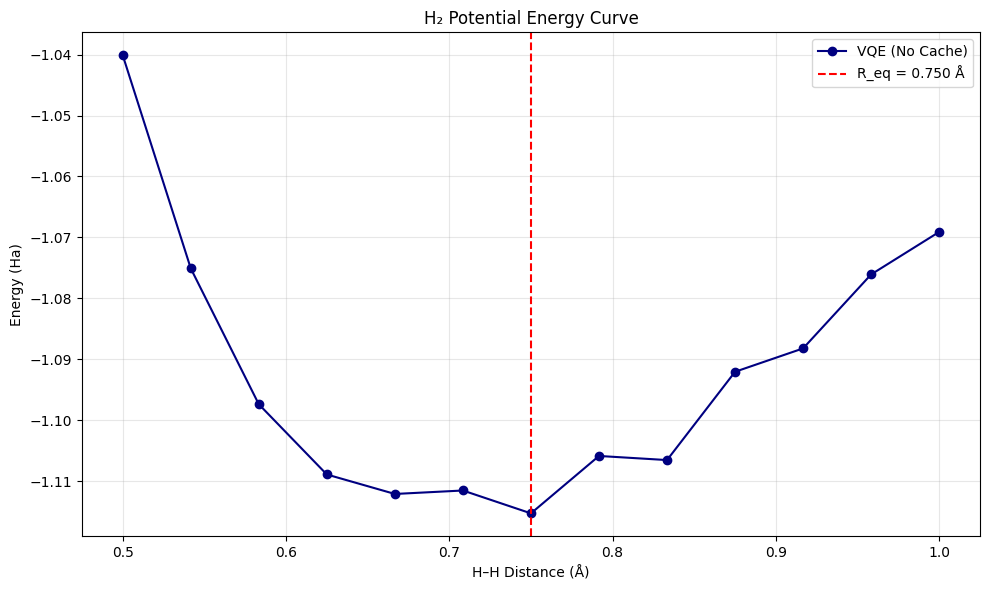


H₂ Ground State:
  R_eq = 0.750 Å
  E_min = -1.115303 Ha
  (실험값: R = 0.741 Å, E ≈ -1.174 Ha)


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(distances, energies_h2, 'o-', color='navy', label='VQE')
plt.axvline(r_eq, color='red', ls='--', label=f'R_eq = {r_eq:.3f} Å')
plt.xlabel('H–H Distance (Å)')
plt.ylabel('Energy (Ha)')
plt.title('H₂ Potential Energy Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nH₂ Ground State:")
print(f"  R_eq = {r_eq:.3f} Å")
print(f"  E_min = {e_min:.6f} Ha")
print(f"  (실험값: R = 0.741 Å, E ≈ -1.174 Ha)")